<a href="https://colab.research.google.com/github/MeldaChen/Group-4/blob/main/image_find_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

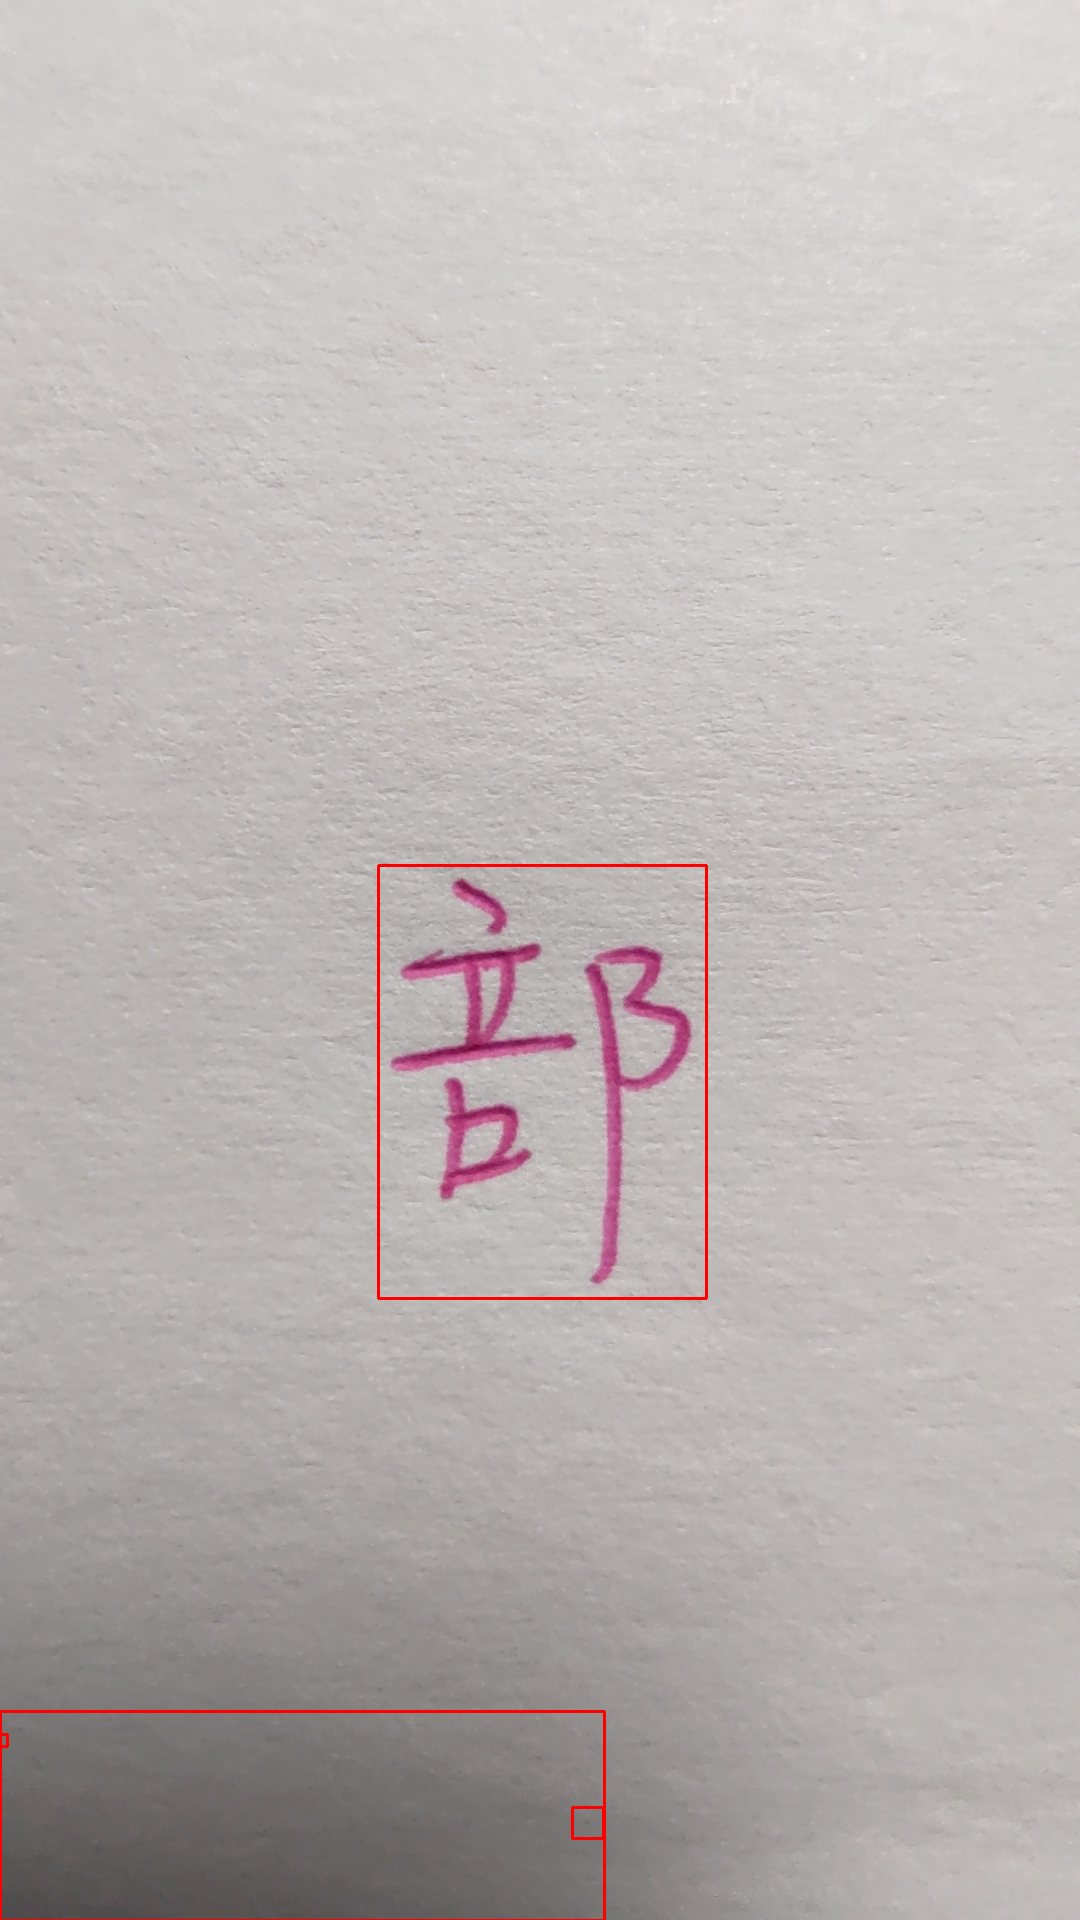

---------


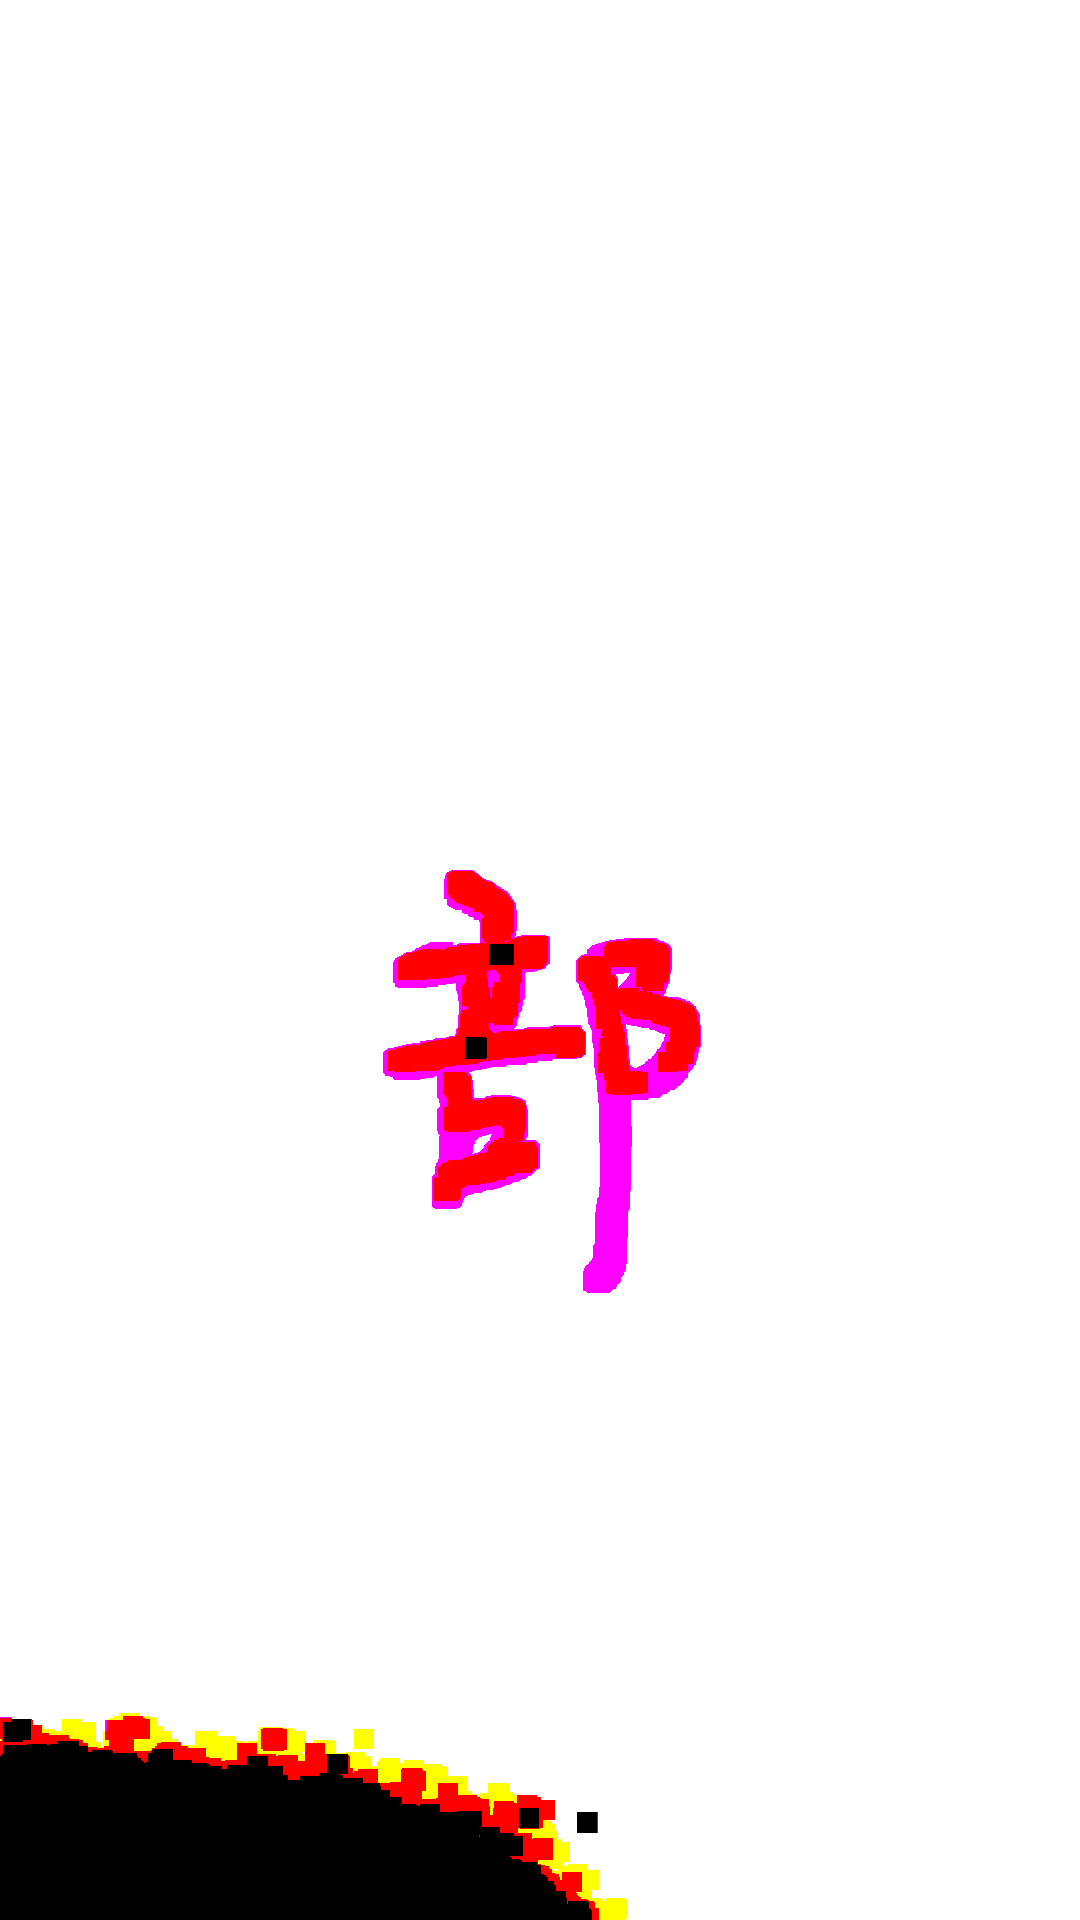

---------


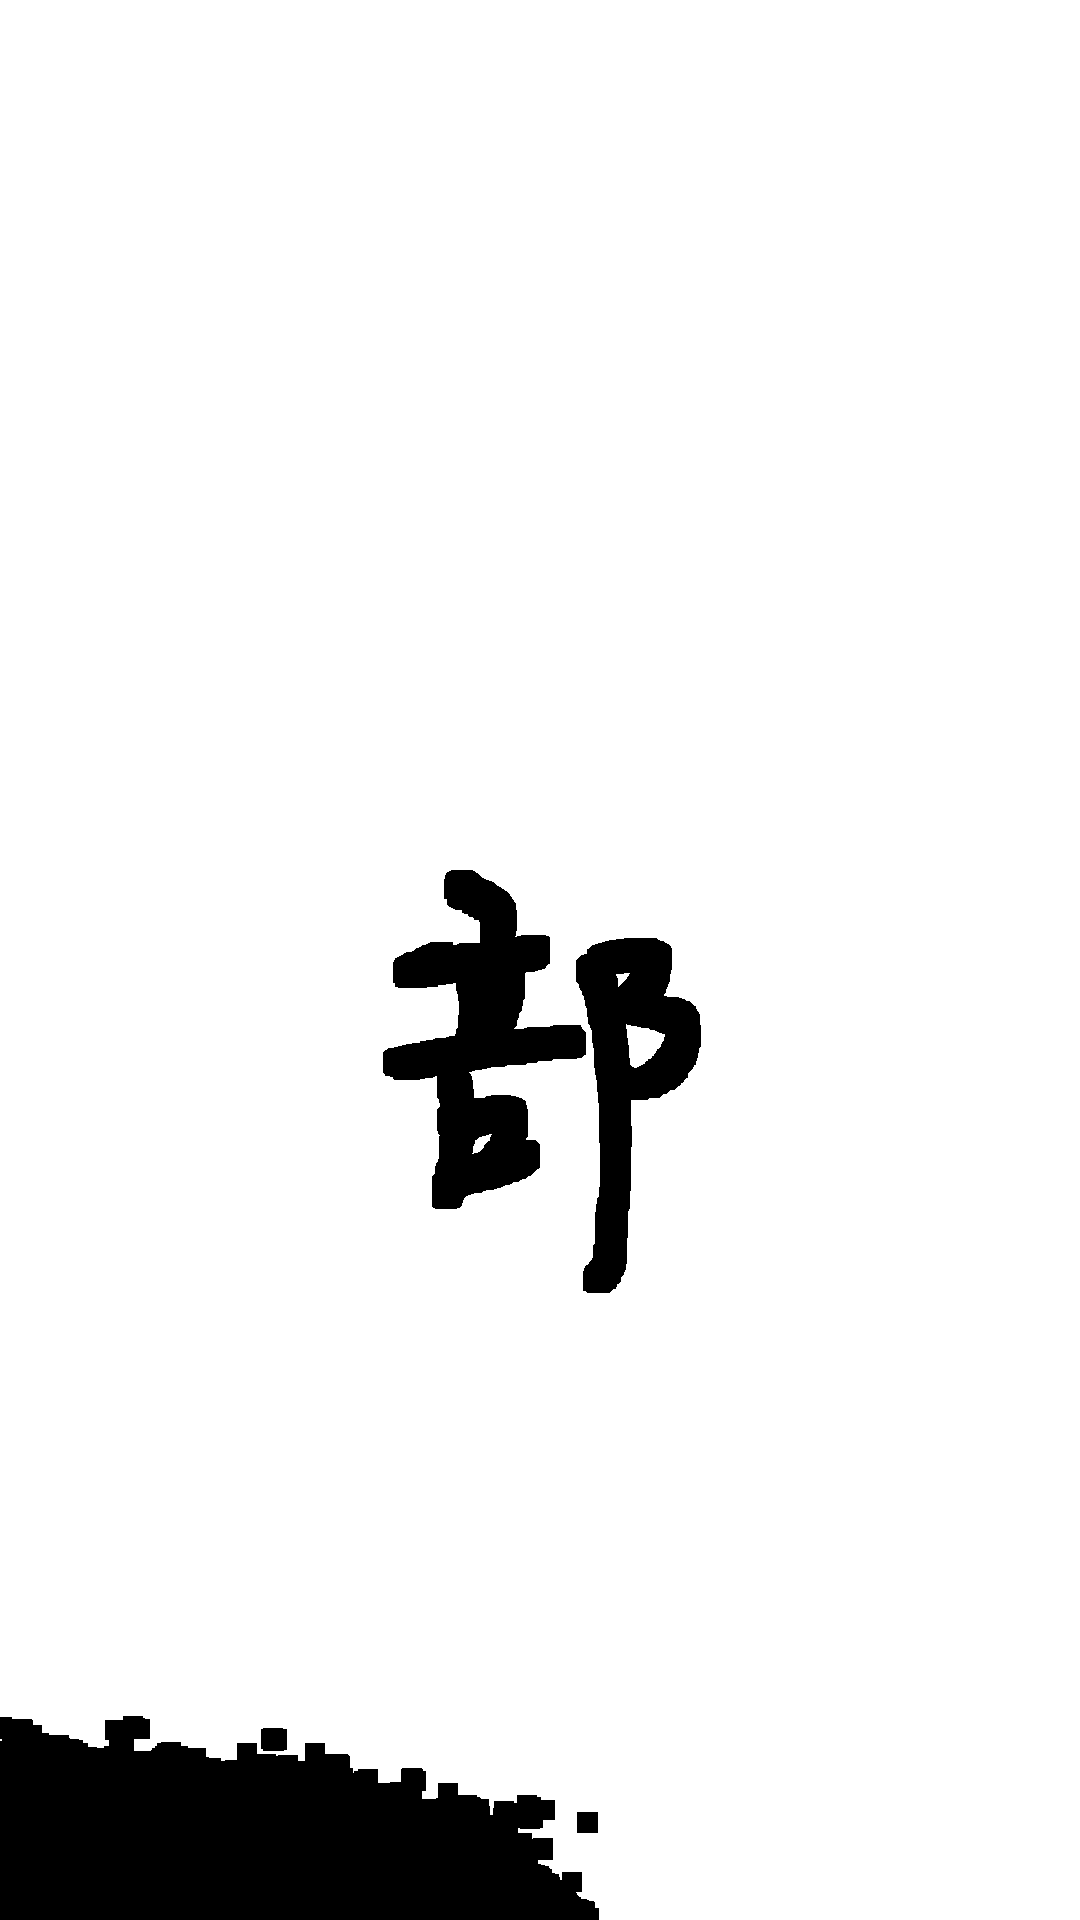

In [2]:
# 裁切等辨識後再裁？
# 分開的字如何框在一起，如 e024 個
# 明亮度、模糊化

import cv2
import numpy as np
import IPython.display as dp
from google.colab.patches import cv2_imshow

m1 = cv2.imread('A039.jpg', 1)

copy = m1.copy()

erode = cv2.erode(copy, np.ones((20, 20))) #抓字

th, thres = cv2.threshold(erode, 110, 255, cv2.THRESH_BINARY) #二值化去背



gray = cv2.cvtColor(thres, cv2.COLOR_BGR2GRAY) #轉灰階

th, thres_2 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU) #二值化去背again

canny = cv2.Canny(thres_2, 0, 90)

th, canny = cv2.threshold(canny, 10, 255, cv2.THRESH_BINARY)

morph = cv2.morphologyEx(canny, cv2.MORPH_GRADIENT, np.ones((10, 10))) 
p, t = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 

for i in range(0, len(p), 1): 
    x, y, w, h = cv2.boundingRect(p[i]) 
    cv2.rectangle(m1, (x,y), (x+w, y+h), (0, 0, 255), 2)

cv2_imshow(m1)
print("---------")
cv2_imshow(thres)
print("---------")
cv2_imshow(thres_2)
# print("---------")
# cv2_imshow(m4)
# print("---------")


In [ ]:
#Enos老師的影像辨識碼

@handler.add(MessageEvent, message=ImageMessage)
def handle_message(event):
    message_id = event.message.id
    message_content = line_bot_api.get_message_content(message_id)
        
    b = b''
    for chunk in message_content.iter_content():
        b += chunk
    img = Image.open(io.BytesIO(b))
    r = classify(img)
    line_bot_api.reply_message(
        event.reply_token,
        TextSendMessage(text=r))


def classify(img):
    img = ImageOps.fit(img, model.input.shape[1:3])
    prediction = model.predict(np.expand_dims(img, axis=0)/255.)
    p = np.argmax(prediction)
    with open(label, encoding='utf-8') as f:
        labels = f.read().split()
    return labels[p] if 0 <= p < len(labels) else 'unknown'